# Downloading libraries

In [ ]:
# Загрузка библиотек ai_tr_libs с github
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/make_y.py
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/dataloader.py
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Long_n_short_strategy.py
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Long_strategy.py
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Dataset.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2470  100  2470    0     0  10977      0 --:--:-- --:--:-- --:--:-- 11026
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11269  100 11269    0     0  23824      0 --:--:-- --:--:-- --:--:-- 23774
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   814  100   814    0     0   4153      0 --:--:-- --:--:-- --:--:--  4153
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   607  100   607    0     0   2876      0 --:--:-- --:--:-- --:--:--  2863
  % Total    % Received % Xferd  Average Speed   Tim

In [ ]:
!pip install backtesting

     |████████████████████████████████| 184kB 11.0MB/s 
  Created wheel for backtesting: filename=Backtesting-0.3.1-cp37-none-any.whl size=173815 sha256=77f36ce018aa0cac546b31da05d40c575ad5cada64d217894e0d15149d1fcbe9
  Stored in directory: /root/.cache/pip/wheels/df/f7/2c/3243474df133eaf7feaba41d1f44f7d7727c264385a59927aa
Successfully built backtesting


In [ ]:
!pip install tulipy

     |████████████████████████████████| 112kB 10.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for tulipy: filename=tulipy-0.4.0-cp37-cp37m-linux_x86_64.whl size=227733 sha256=9557ccb54ed7b12ccf1c8b8fef1d4a7188c6285397cdb5b5c89cc5b4d03f8490
  Stored in directory: /root/.cache/pip/wheels/c7/17/ad/a187769379c3b970acfd4aabe82e8e2b4dfca2b518a26de957
Successfully built tulipy


## Подключение библиотек

In [ ]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils

from keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder # проверить все

from keras.preprocessing.sequence import TimeseriesGenerator

# Библиоетки backtesting
from backtesting import Backtest, Strategy

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pandas import DataFrame as df

import tulipy as tl

from tensorflow.keras import backend as K

# Библиотеки из ai_tr_libs
from make_y import Super_Dooper
from dataloader import Dataloader as dl
from Long_n_short_strategy import Long_n_Short_Strategy as LnS
from Long_strategy import Long_Strategy as LS
from Dataset import Dataset

from tensorflow.keras.utils import plot_model
from IPython.display import clear_output

/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


# Общие данные

In [ ]:
# Общие переменные для обучения 
ticker = 'POLY'
frame_size = 10
ensemble = 40
batch_size = 100
period = 'hour'

dataset_test_size = 2000
dataset_val_size = 400
val_test_gap = 1000
train_val_gap = 10

cash = 10000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/_Проекты/AI_Trading/AI_Trading_Lab/testing')

Mounted at /content/drive


# <font color="red">Загрузка и обработка данных для обучения<font color="red">

In [ ]:
# Используем класс dataloader (dl) для загрузки данных с Финам
data = dl(ticker, period, start_date='01-01-2019', save_to_file=False, capitalize=True).get_data()
data = data[:-1]
# Класс Super_Dooper из модуля make_y помогает разметить y
maker = Super_Dooper(frame_size)
data = maker.mark_y(data)
# Удаляем наниты
data.dropna(axis=0, inplace=True)
print(data.shape)
data[-5:]

(44, 10)


,Ticker,Per,Date,Time,Open,High,Low,Close,Vol,Signal
datetime,,,,,,,,,,
2021-04-07 10:00:00,175924,60,20210407,100000,1537.4,1543.6,1528.4,1539.6,226817,-1.0
2021-04-07 11:00:00,175924,60,20210407,110000,1539.9,1540.0,1532.3,1534.1,82090,-1.0
2021-04-07 12:00:00,175924,60,20210407,120000,1534.1,1536.0,1532.5,1533.0,37508,-1.0
2021-04-07 13:00:00,175924,60,20210407,130000,1533.0,1533.3,1526.1,1528.2,50627,-1.0
2021-04-07 14:00:00,175924,60,20210407,140000,1528.2,1528.5,1524.5,1526.4,47929,1.0


## Train, Val, Test датасет генераторы

In [ ]:
# Создаем экземпляр класса Dataset на базе входных данных с размеченным y 
# при создании указываем размер batch_size и ensemble, по умолчанию y будет преобразован в one_hot_encoded вектор
ds = Dataset(data, batch_size, ensemble, drop_signal=True, date_to_feat=True)

# Устанавливаем границы test, val и train датасетов 
# В классе 6 параметров - m_start_index, m_end_index, где m = {train, val, test} 
# По умолчанию начало каждого датасета равно 0 а конец - крайний элемент в массиве
# Вычитаем из хвоста размер тестового датасета - получаем его начало, 
# вычитаем от начала test датасет 1 - получаем конец val датасета
# Аналогично для train
ds.test_start_index = ds.test_end_index - dataset_test_size
ds.val_end_index = ds.test_start_index - val_test_gap
ds.val_start_index = ds.val_end_index - dataset_val_size
ds.train_end_index = ds.val_start_index - train_val_gap
#print(ds.train_end_index)

In [ ]:
print(ds.train()[0][0].shape)
ds.train()[0][0][0][0] # это X

(4, 40, 10)


array([-2.85474391e-02,  3.69230769e-02, -1.58227848e-03,  3.89610390e-02,
        3.58275257e-02,  1.20000000e+00,  0.00000000e+00, -4.00000000e+00,
       -1.71428571e+00, -4.07604266e-01])

In [ ]:
ds.train()[0][1][0] # это Y

array([1., 0.])

# Сеть

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/AI_Trading/AI_Trading_Lab/testing/POLY_Conv_hour_10_40.h5')

## Создание сети

In [ ]:
"""def base_layer(input, filters, k_size, pool_size=(2,1), act='elu'):
  x = Conv2D(filters, k_size, padding = 'same', activation=act)(input)
  xa = AveragePooling2D(pool_size=pool_size, padding='same')(x)
  xm = MaxPooling2D(pool_size=pool_size, padding='same')(x)
  xa = Conv2D(filters, k_size, padding='same', activation=act)(xa)
  xm = Conv2D(filters, k_size, padding='same', activation=act)(xm)
  x = concatenate([xa,xm])
  x = Conv2D(filters, k_size, padding='same', activation=act)(x)
  return x

k_size = (3,3)

input_shape = (*ds.input_shape, 1)
input_layer = Input(shape=input_shape)

x = Conv2D(64, k_size, padding = 'same', activation='elu')(input_layer)
x = base_layer(x, 64, k_size, act='elu')
x = base_layer(x, 128, k_size, act='elu')
x = base_layer(x, 64, k_size, act='elu')
x = Conv2D(32, k_size, padding = 'same', activation='elu')(x)
x = Conv2D(8, k_size, padding = 'same', activation='elu')(x)
x = Flatten()(x)
x = Dense(12, activation='tanh')(x)
x = Dense(2, activation = 'softmax')(x)

model = Model(input_layer, x)"""

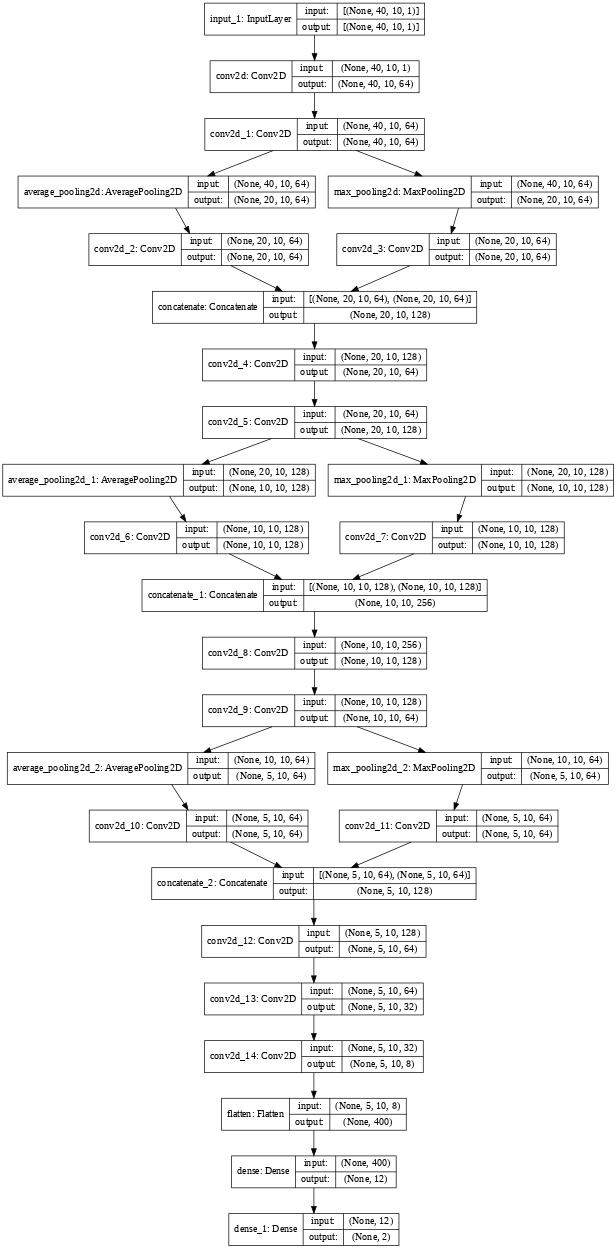

In [ ]:
from tensorflow.keras.utils import plot_model
#print(model.summary()) #Вывод структуры модели
plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)

## Обучение

In [ ]:
"""model.compile(optimizer=Adam(learning_rate = 5e-05),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']) 

early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 12, verbose = 0, 
                               restore_best_weights = True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 0)

model_file_name = f'{ticker}_Conv_{period}_{frame_size}_{ensemble}.h5'
checkpoint = ModelCheckpoint(model_file_name, monitor='val_categorical_accuracy', verbose = 0,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(ds.train(), epochs=500, verbose = 1,
                    validation_data=ds.val(),
                    callbacks = [early_stopping, reduce_lr, checkpoint])
"""

In [ ]:
"""plt.figure(figsize=(6,4))
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()"""

In [ ]:
"""model.evaluate(ds.test())"""

# Проверка модели 08/04

In [ ]:
from datetime import datetime
import pytz     #   pip install pytz

moscow_time = datetime.now(pytz.timezone('Europe/Moscow'))
print(moscow_time.strftime("%d-%m-%Y %H:%M:%S"))
print(moscow_time.date())
print(moscow_time.hour)
print(moscow_time.minute)
print(moscow_time.second)

In [ ]:
intraday_trades = pd.DataFrame()
moscow_time = datetime.now(pytz.timezone('Europe/Moscow'))
while moscow_time.hour > 9 and moscow_time.hour < 19:
    moscow_time = datetime.now(pytz.timezone('Europe/Moscow'))
    if moscow_time.minute == 1 and moscow_time.second == 1 and moscow_time.microsecond < 10:

        # Используем класс dataloader (dl) для загрузки данных с Финам
        data = dl(ticker, period, start_date='01-01-2019', save_to_file=False, capitalize=True).get_data()
        data = data[:-1]
        # Класс Super_Dooper из модуля make_y помогает разметить y
        maker = Super_Dooper(frame_size)
        data = maker.mark_y(data)
        # Удаляем наниты
        data.dropna(axis=0, inplace=True)

        # Создаем экземпляр класса Dataset на базе входных данных с размеченным y 
        # при создании указываем размер batch_size и ensemble, по умолчанию y будет преобразован в one_hot_encoded вектор
        ds = Dataset(data, batch_size, ensemble, drop_signal=True, date_to_feat=True)

        # Устанавливаем границы test, val и train датасетов 
        # В классе 6 параметров - m_start_index, m_end_index, где m = {train, val, test} 
        # По умолчанию начало каждого датасета равно 0 а конец - крайний элемент в массиве
        # Вычитаем из хвоста размер тестового датасета - получаем его начало, 
        # вычитаем от начала test датасет 1 - получаем конец val датасета
        # Аналогично для train
        ds.test_start_index = ds.test_end_index - dataset_test_size
        ds.val_end_index = ds.test_start_index - val_test_gap
        ds.val_start_index = ds.val_end_index - dataset_val_size
        ds.train_end_index = ds.val_start_index - train_val_gap
        #print(ds.train_end_index)

        # predict
        pred = model.predict(ds.test())
        ddd = ds.test_prep_dec(pred)
        intraday_trades = intraday_trades.append(ddd[-1:])
        intraday_trades.to_csv(f'intraday_trades_{ticker}_Conv_1{period}_{frame_size}_{ensemble}_{moscow_time.date()}_безПО.csv', sep=',')
# ========================================== OUTPUT RESALTS====================================
        clear_output()
        print(intraday_trades)
        print()
        # Стратегия Long & Short (подключен класс стратегии LnS)
        bt = Backtest(intraday_trades, LnS, cash=cash, commission=.004, trade_on_close=True)
        stats = bt.run()
        bt.plot(plot_volume=True, relative_equity=True)
        print()
        stats
        #print(moscow_time)
    continue


In [ ]:
intraday_trades

In [ ]:
# Стратегия Long & Short (подключен класс стратегии LnS)
bt = Backtest(intraday_trades, LnS, cash=cash, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)

In [ ]:
stats

# Проверка модели 07/04

In [ ]:
from datetime import datetime
import pytz     #   pip install pytz

moscow_time = datetime.now(pytz.timezone('Europe/Moscow'))
print(moscow_time.strftime("%d-%m-%Y %H:%M:%S"))
print(moscow_time.date())
print(moscow_time.hour)
print(moscow_time.minute)
print(moscow_time.second)

07-04-2021 09:08:16
2021-04-07
9
8
16


In [ ]:
from datetime import datetime
import pytz     #pip install pytz

#intraday_trades = pd.DataFrame()
moscow_time = datetime.now(pytz.timezone('Europe/Moscow'))
while moscow_time.hour > 9 and moscow_time.hour < 19:
    moscow_time = datetime.now(pytz.timezone('Europe/Moscow'))
    if moscow_time.minute == 1 and moscow_time.second == 1 and moscow_time.microsecond < 10:

        # Используем класс dataloader (dl) для загрузки данных с Финам
        data = dl(ticker, period, start_date='01-01-2019', save_to_file=False, capitalize=True).get_data()
        data = data[:-1]
        # Класс Super_Dooper из модуля make_y помогает разметить y
        maker = Super_Dooper(frame_size)
        data = maker.mark_y(data)
        # Удаляем наниты
        data.dropna(axis=0, inplace=True)

        # Создаем экземпляр класса Dataset на базе входных данных с размеченным y 
        # при создании указываем размер batch_size и ensemble, по умолчанию y будет преобразован в one_hot_encoded вектор
        ds = Dataset(data, batch_size, ensemble, drop_signal=True, date_to_feat=True)

        # Устанавливаем границы test, val и train датасетов 
        # В классе 6 параметров - m_start_index, m_end_index, где m = {train, val, test} 
        # По умолчанию начало каждого датасета равно 0 а конец - крайний элемент в массиве
        # Вычитаем из хвоста размер тестового датасета - получаем его начало, 
        # вычитаем от начала test датасет 1 - получаем конец val датасета
        # Аналогично для train
        ds.test_start_index = ds.test_end_index - dataset_test_size
        ds.val_end_index = ds.test_start_index - val_test_gap
        ds.val_start_index = ds.val_end_index - dataset_val_size
        ds.train_end_index = ds.val_start_index - train_val_gap
        #print(ds.train_end_index)

        # predict
        pred = model.predict(ds.test())
        ddd = ds.test_prep_dec(pred)
        intraday_trades = intraday_trades.append(ddd[-1:])
        intraday_trades.to_csv(f'intraday_trades_{ticker}_Conv_1{period}_{frame_size}_{ensemble}_{moscow_time.date()}_безПО.csv', sep=',')
# ========================================== OUTPUT RESALTS====================================
        clear_output()
        print(intraday_trades)
        print()
        # Стратегия Long & Short (подключен класс стратегии LnS)
        bt = Backtest(intraday_trades, LnS, cash=cash, commission=.004, trade_on_close=True)
        stats = bt.run()
        bt.plot(plot_volume=True, relative_equity=True)
        print()
        stats
        #print(moscow_time)
    continue


## Второй тест

In [ ]:
intraday_trades

,Open,High,Low,Close,Signal
2021-04-07 15:00:00,1525.8,1534.9,1521.5,1534.9,1.0
2021-04-07 16:00:00,1534.1,1534.7,1526.5,1532.3,1.0
2021-04-07 17:00:00,1532.0,1532.8,1520.1,1523.6,1.0
2021-04-07 17:00:00,1532.0,1532.8,1520.1,1523.6,1.0


In [ ]:
# Стратегия Long & Short (подключен класс стратегии LnS)
bt = Backtest(intraday_trades, LnS, cash=cash, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)

In [ ]:
stats

Start                     2021-04-07 15:00:00
End                       2021-04-07 17:00:00
Duration                      0 days 02:00:00
Exposure Time [%]                          50
Equity Final [$]                      9911.02
Equity Peak [$]                         10000
Return [%]                          -0.889752
Buy & Hold Return [%]               -0.736204
Return (Ann.) [%]                           0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                                0
Max. Drawdown [%]                   -0.889752
Avg. Drawdown [%]                   -0.889752
Max. Drawdown Duration        0 days 01:00:00
Avg. Drawdown Duration        0 days 01:00:00
# Trades                                    1
Win Rate [%]                                0
Best Trade [%]                      -0.963918
Worst Trade [%]                     -0.963918
Avg. Trade [%]                    

## Первый тест

In [ ]:
        print(intraday_trades)
        print()
        # Стратегия Long & Short (подключен класс стратегии LnS)
        bt = Backtest(intraday_trades, LnS, cash=cash, commission=.004, trade_on_close=True)
        stats = bt.run()
        bt.plot(plot_volume=True, relative_equity=True)
        print()
        stats
        #print(moscow_time)

                       Open    High     Low   Close  Signal
2021-04-06 23:00:00  1529.0  1532.7  1527.2  1532.7    -1.0
2021-04-07 10:00:00  1537.4  1543.6  1528.4  1539.6     1.0
2021-04-07 11:00:00  1539.9  1540.0  1532.3  1534.1     1.0
2021-04-07 12:00:00  1534.1  1536.0  1532.5  1533.0     1.0
2021-04-07 13:00:00  1533.0  1533.3  1526.1  1528.2     1.0



Start                     2021-04-06 23:00:00
End                       2021-04-07 13:00:00
Duration                      0 days 14:00:00
Exposure Time [%]                          60
Equity Final [$]                      9923.45
Equity Peak [$]                         10000
Return [%]                          -0.765504
Buy & Hold Return [%]                 -0.2936
Return (Ann.) [%]                    -62.0251
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                   -0.765504
Avg. Drawdown [%]                   -0.765504
Max. Drawdown Duration        0 days 03:00:00
Avg. Drawdown Duration        0 days 03:00:00
# Trades                                    1
Win Rate [%]                                0
Best Trade [%]                      -0.825381
Worst Trade [%]                     -0.825381
Avg. Trade [%]                    

In [ ]:
intraday_trades

,Open,High,Low,Close,Signal
2021-04-06 23:00:00,1529.0,1532.7,1527.2,1532.7,-1.0
2021-04-07 10:00:00,1537.4,1543.6,1528.4,1539.6,1.0
2021-04-07 11:00:00,1539.9,1540.0,1532.3,1534.1,1.0
2021-04-07 12:00:00,1534.1,1536.0,1532.5,1533.0,1.0
2021-04-07 13:00:00,1533.0,1533.3,1526.1,1528.2,1.0


In [ ]:
stats

Start                     2021-04-06 23:00:00
End                       2021-04-07 13:00:00
Duration                      0 days 14:00:00
Exposure Time [%]                          60
Equity Final [$]                      9923.45
Equity Peak [$]                         10000
Return [%]                          -0.765504
Buy & Hold Return [%]                 -0.2936
Return (Ann.) [%]                    -62.0251
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                   -0.765504
Avg. Drawdown [%]                   -0.765504
Max. Drawdown Duration        0 days 03:00:00
Avg. Drawdown Duration        0 days 03:00:00
# Trades                                    1
Win Rate [%]                                0
Best Trade [%]                      -0.825381
Worst Trade [%]                     -0.825381
Avg. Trade [%]                    